In [59]:
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_32x32BN.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


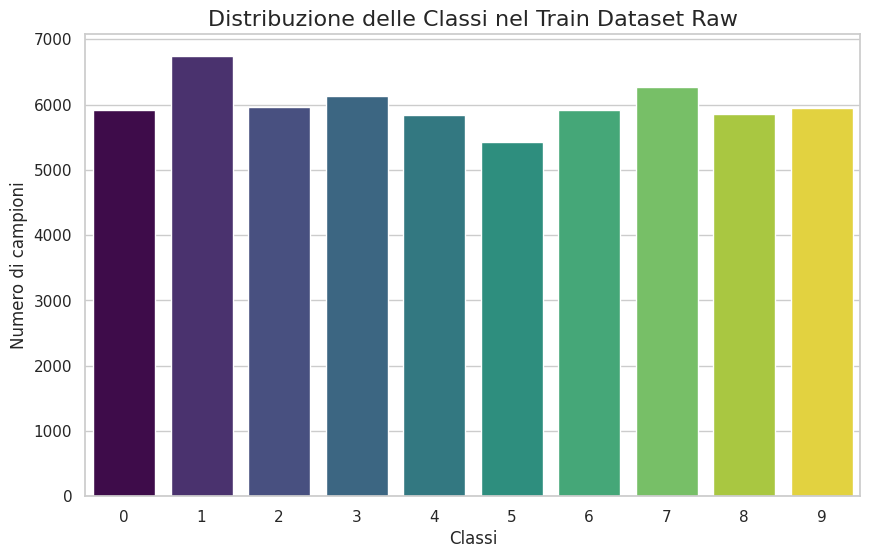

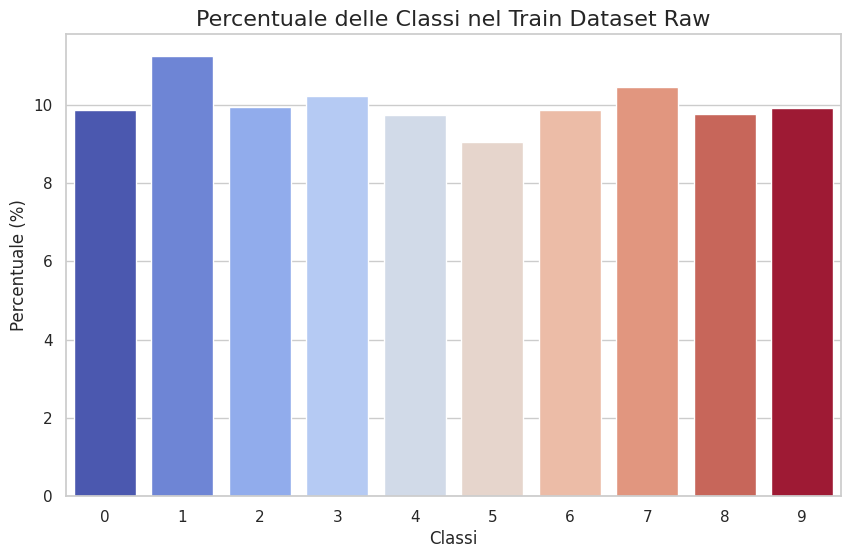

In [3]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




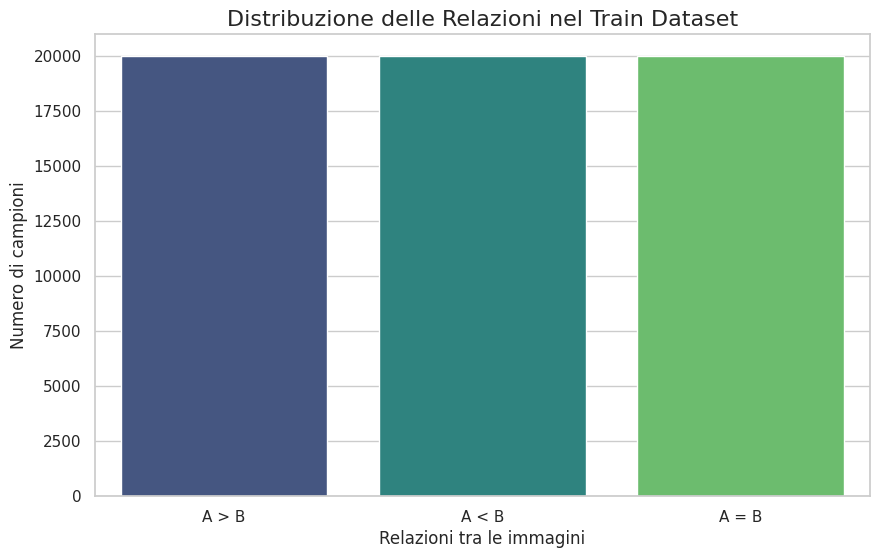

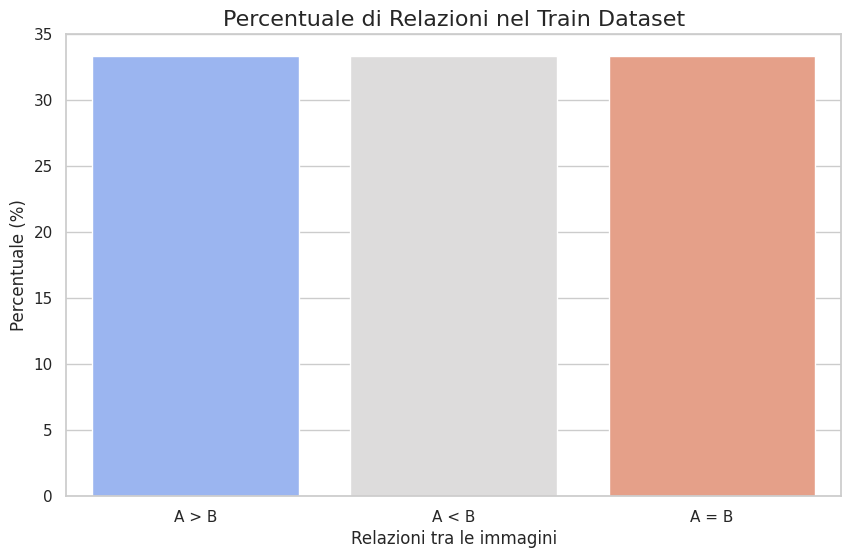

In [4]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 990, 2: 1021, 0: 989}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 1: 990 campioni (33.00%)
Relazione 2: 1021 campioni (34.03%)
Relazione 0: 989 campioni (32.97%)




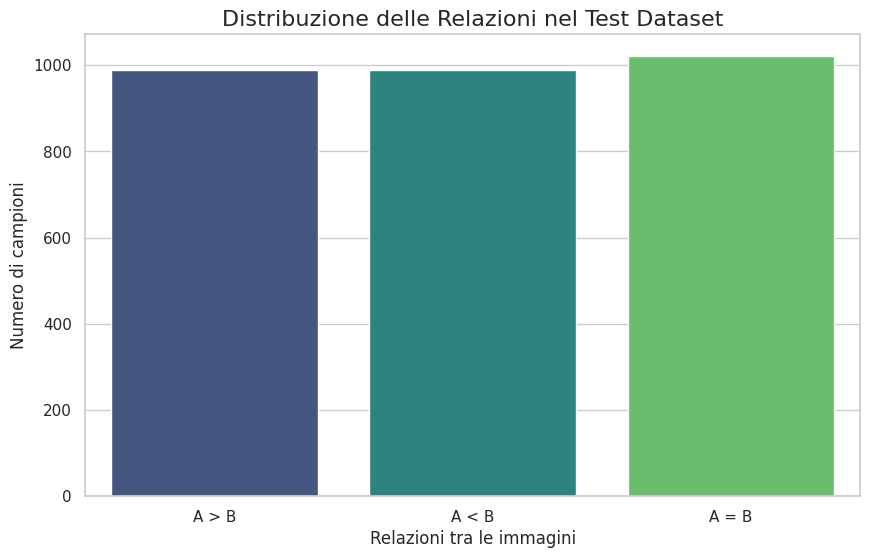

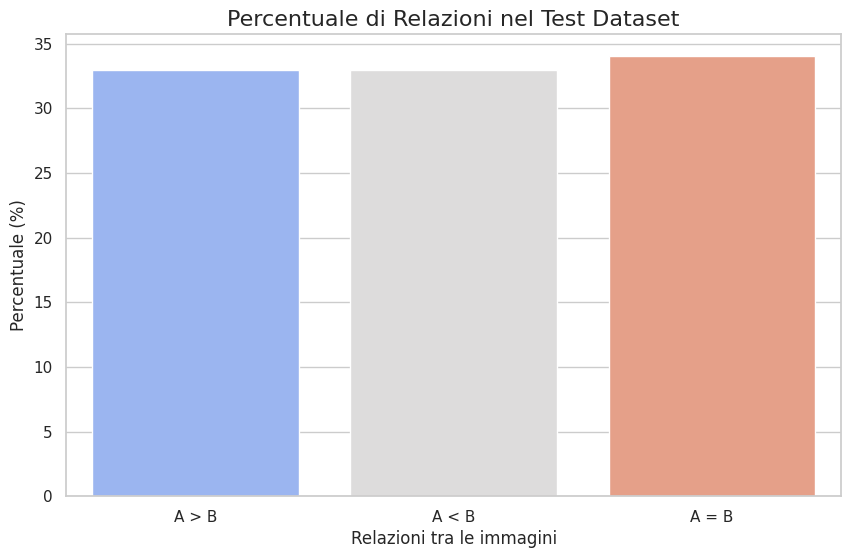

In [5]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2344, 1: 2343, 2: 2312}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2344 campioni (33.49%)
Relazione 1: 2343 campioni (33.48%)
Relazione 2: 2312 campioni (33.03%)




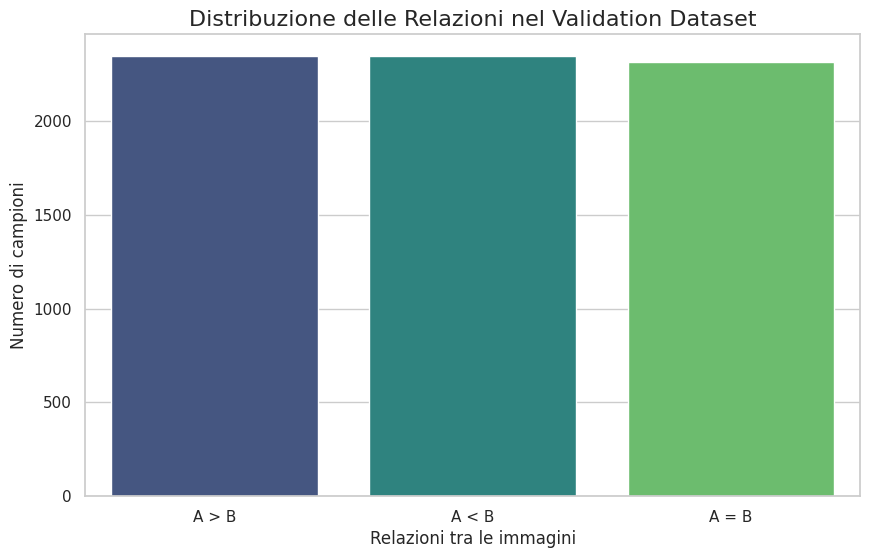

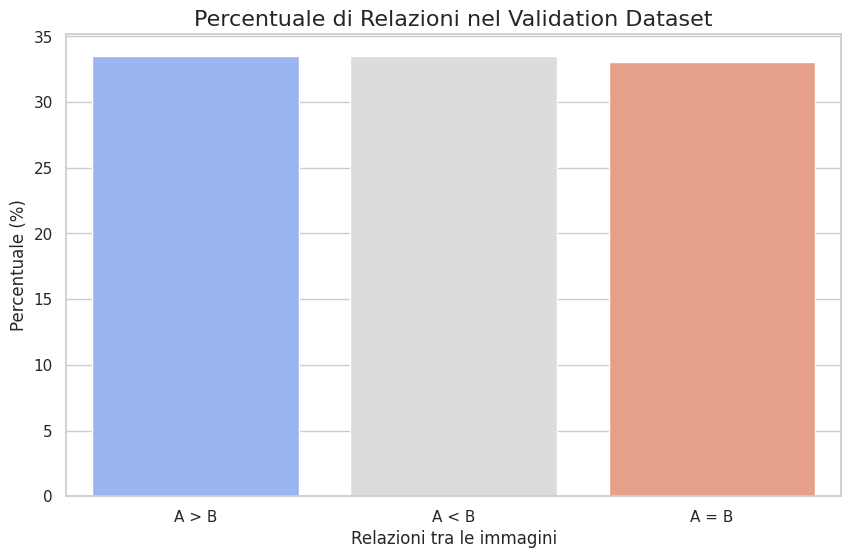

In [6]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [7]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [8]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [77]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        
        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)  # BatchNorm for first conv layer
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)  # BatchNorm for second conv layer
        
        # Fully connected layers with Batch Normalization
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)  # BatchNorm for first FC layer
        
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)  # BatchNorm for second FC layer
        
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # Convolutional layers with ReLU and MaxPooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        # Flatten the tensor
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers with ReLU
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        
        # Output layer
        x = self.fc3(x)
        return x

# Instantiate the model
model = CustomLeNet5()
print(model)

CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [78]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

images dtype: torch.float32, labels dtype: torch.int64


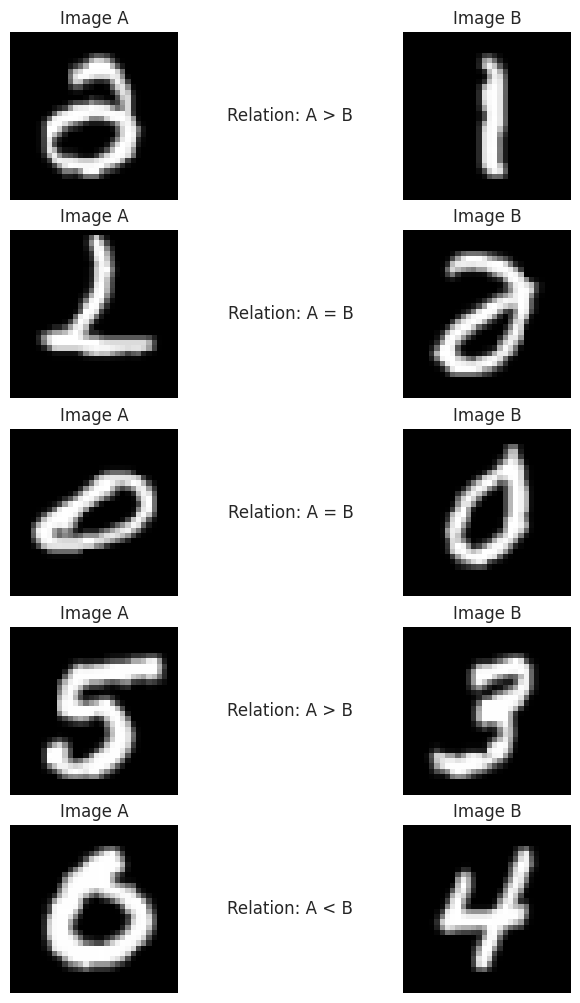

In [79]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32BN_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32BN_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [80]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [81]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.3088: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]


Validating


Loss: 0.4353: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s]
/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch #1 train loss: 0.466 train accuracy: 81.35
Epoch #1 validation loss: 0.435 validation accuracy: 89.16
Learning rate actual:  0.001
Took 0.259 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.2603: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]


Validating


Loss: 0.3526: 100%|██████████| 55/55 [00:00<00:00, 65.79it/s]


Epoch #2 train loss: 0.253 train accuracy: 90.59
Epoch #2 validation loss: 0.353 validation accuracy: 91.16
Learning rate actual:  0.001
Took 0.264 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.2783: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]


Validating


Loss: 0.3166: 100%|██████████| 55/55 [00:00<00:00, 66.30it/s]


Epoch #3 train loss: 0.181 train accuracy: 93.44
Epoch #3 validation loss: 0.317 validation accuracy: 93.46
Learning rate actual:  0.001
Took 0.260 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.1080: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]


Validating


Loss: 0.2736: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s]


Epoch #4 train loss: 0.141 train accuracy: 94.93
Epoch #4 validation loss: 0.274 validation accuracy: 93.91
Learning rate actual:  0.001
Took 0.257 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.1337: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]


Validating


Loss: 0.2341: 100%|██████████| 55/55 [00:00<00:00, 66.50it/s]


Epoch #5 train loss: 0.115 train accuracy: 95.86
Epoch #5 validation loss: 0.234 validation accuracy: 94.18
Learning rate actual:  0.001
Took 0.253 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.0589: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]


Validating


Loss: 0.1628: 100%|██████████| 55/55 [00:00<00:00, 67.60it/s]


Epoch #6 train loss: 0.095 train accuracy: 96.65
Epoch #6 validation loss: 0.163 validation accuracy: 94.93
Learning rate actual:  0.001
Took 0.263 minutes for epoch 6
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.1461: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]


Validating


Loss: 0.2068: 100%|██████████| 55/55 [00:00<00:00, 70.24it/s]


Epoch #7 train loss: 0.083 train accuracy: 97.01
Epoch #7 validation loss: 0.207 validation accuracy: 94.93
Learning rate actual:  0.001
Took 0.234 minutes for epoch 7
No improvement for 1 epoch(s).
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.1508: 100%|██████████| 469/469 [00:12<00:00, 37.84it/s]


Validating


Loss: 0.1234: 100%|██████████| 55/55 [00:00<00:00, 75.80it/s]


Epoch #8 train loss: 0.071 train accuracy: 97.43
Epoch #8 validation loss: 0.123 validation accuracy: 95.07
Learning rate actual:  0.001
Took 0.219 minutes for epoch 8
Checkpoint saved at epoch 8.

EPOCH 9 of 30
Training


Loss: 0.0967: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]


Validating


Loss: 0.1373: 100%|██████████| 55/55 [00:00<00:00, 56.39it/s]


Epoch #9 train loss: 0.063 train accuracy: 97.74
Epoch #9 validation loss: 0.137 validation accuracy: 95.09
Learning rate actual:  0.001
Took 0.269 minutes for epoch 9
No improvement for 1 epoch(s).
Checkpoint saved at epoch 9.

EPOCH 10 of 30
Training


Loss: 0.0634: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]


Validating


Loss: 0.1704: 100%|██████████| 55/55 [00:00<00:00, 67.05it/s]


Epoch #10 train loss: 0.054 train accuracy: 98.08
Epoch #10 validation loss: 0.170 validation accuracy: 95.06
Learning rate actual:  0.001
Took 0.260 minutes for epoch 10
No improvement for 2 epoch(s).
Checkpoint saved at epoch 10.

EPOCH 11 of 30
Training


Loss: 0.1111: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]


Validating


Loss: 0.1429: 100%|██████████| 55/55 [00:00<00:00, 63.74it/s]


Epoch #11 train loss: 0.045 train accuracy: 98.45
Epoch #11 validation loss: 0.143 validation accuracy: 95.46
Learning rate actual:  0.001
Took 0.261 minutes for epoch 11
No improvement for 3 epoch(s).
Early stopping triggered after 11 epochs.
Checkpoint saved at epoch 11.
Validating


Loss: 0.0387: 100%|██████████| 24/24 [00:00<00:00, 75.08it/s]

Test loss: 0.039 Test accuracy: 95.87


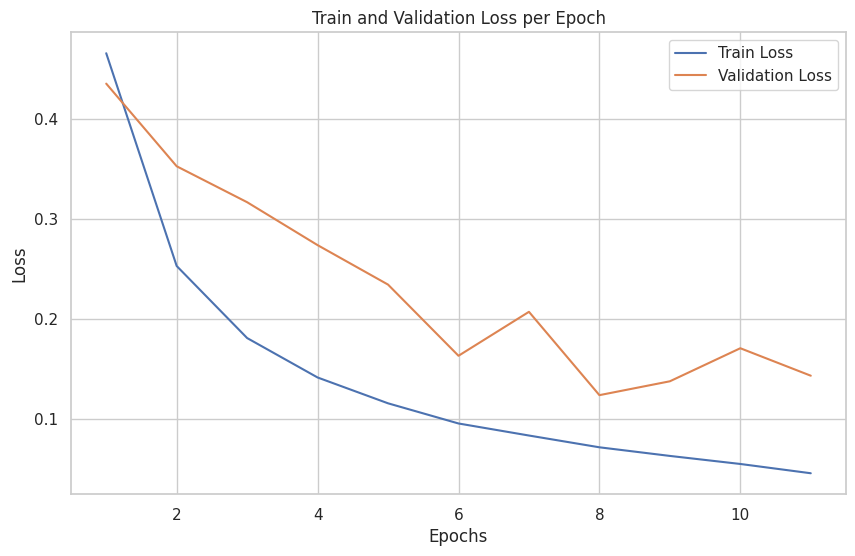

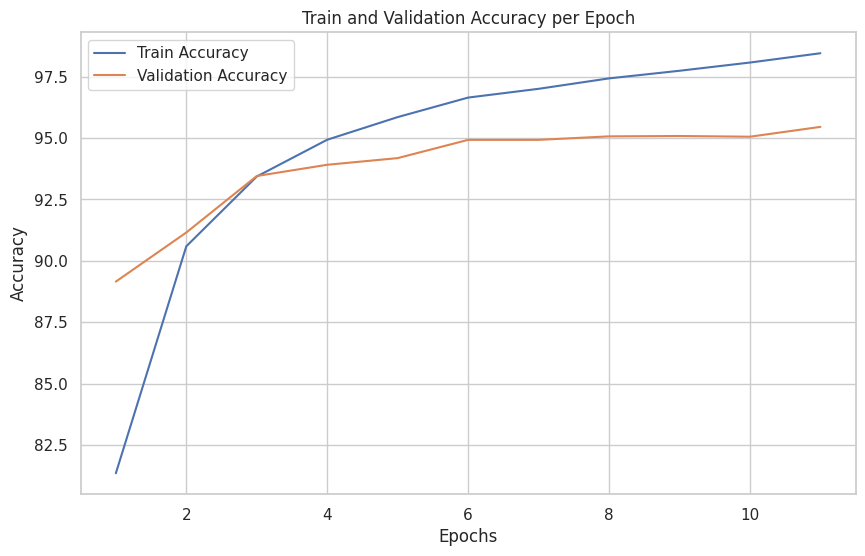

In [82]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

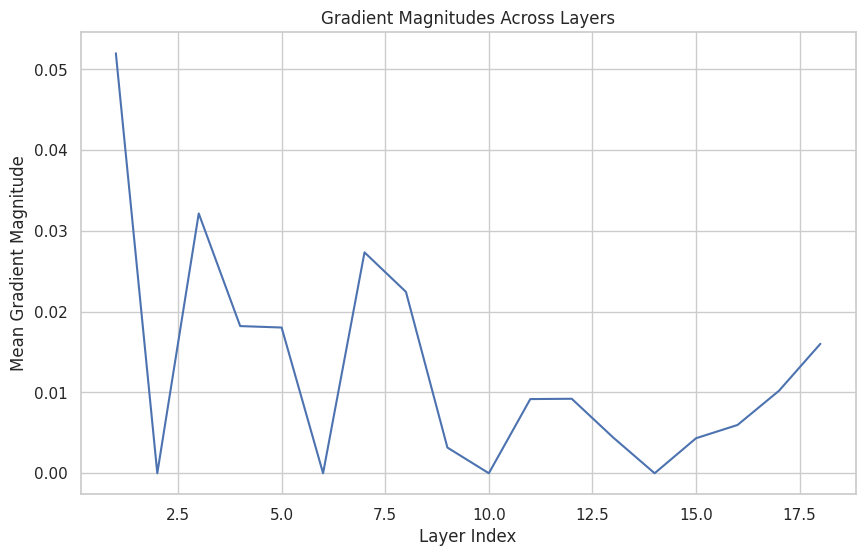

In [83]:
utils.plot_gradient(model)

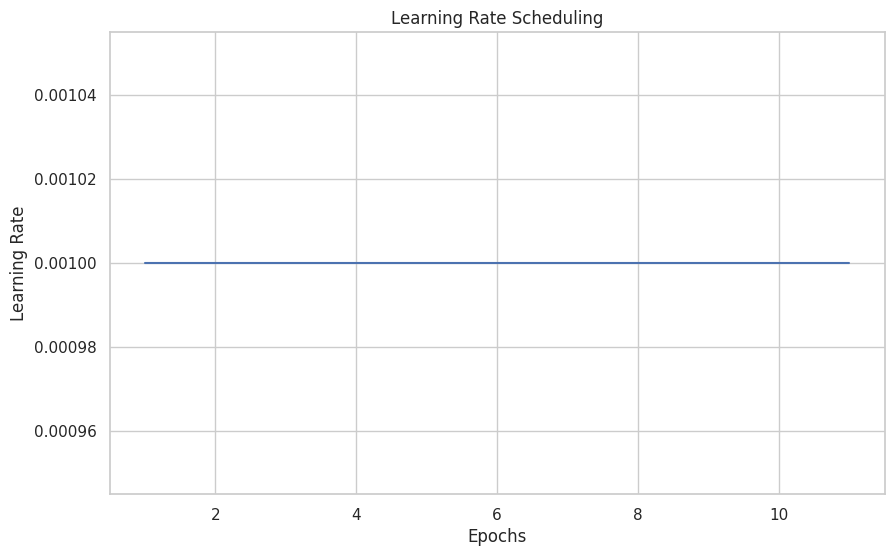

In [84]:
utils.plot_lr_scheduler(lr_history)

In [85]:
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference(model, validation_loader, device)
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference(model, test_loader, device)

288 previsioni errate trovate.


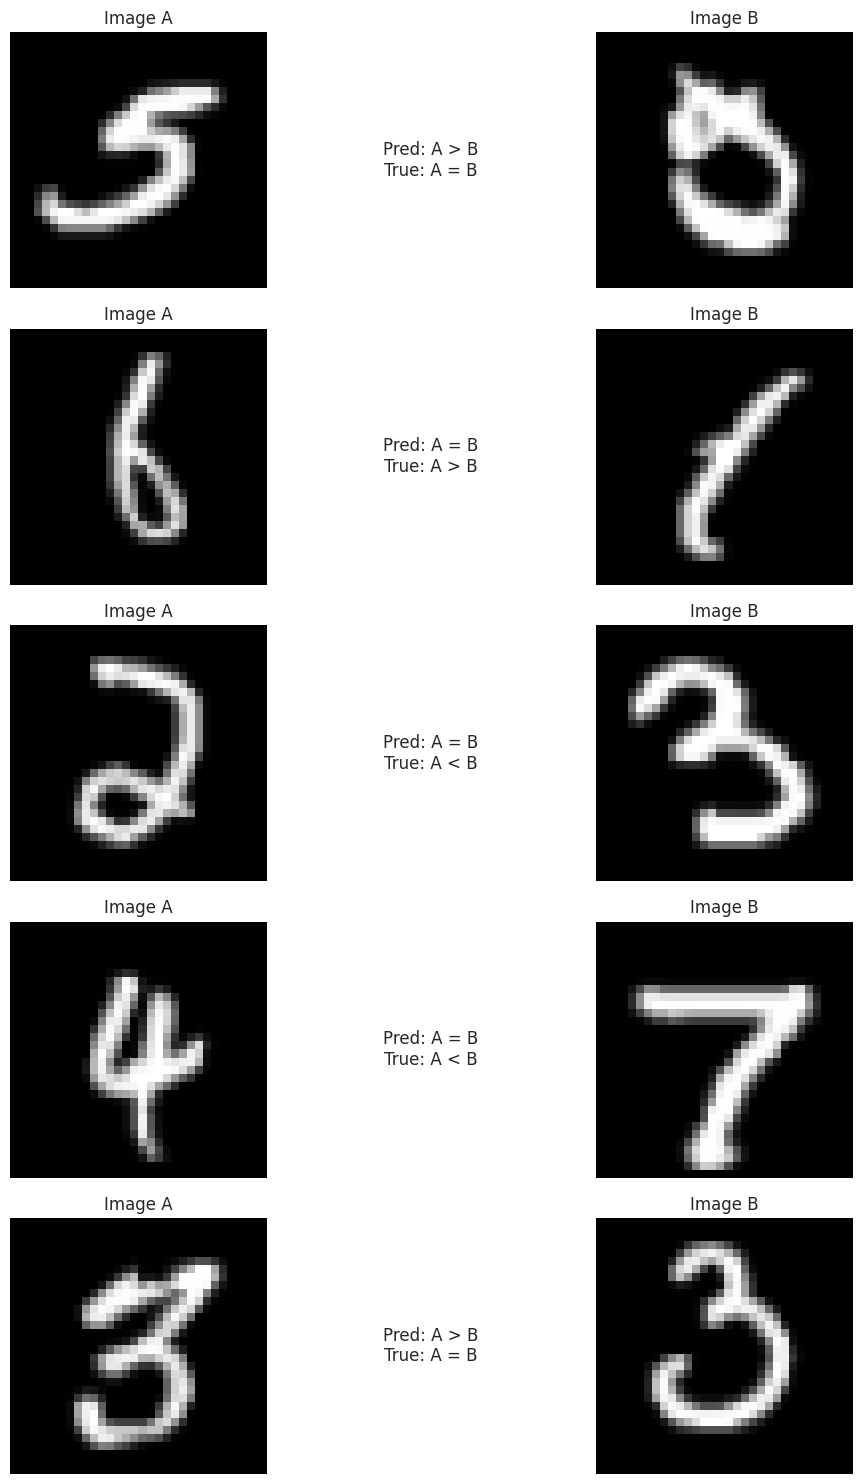

In [86]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_validation', utils.show_incorrect_predictions(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, num_images=5))

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, num_images=5))

124 previsioni errate trovate.


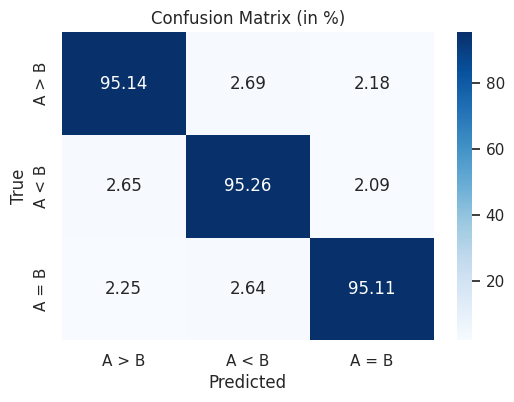

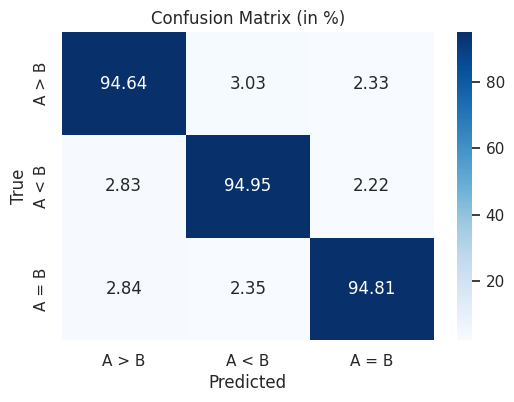

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)

              precision    recall  f1-score   support

       A > B       0.94      0.95      0.94       989
       A < B       0.95      0.95      0.95       990
       A = B       0.96      0.95      0.95      1021

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32BN_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32BN_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32BN"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32_BN.ipynb')


Notebook saved as run32x32BN_BS=128_LR=0.001_EPOCHS=30_AUG=False_TRA=False_OPT=ADAM_1.ipynb


In [ ]:
writer.close()